In [2]:
import numpy as np
from scipy.stats import multivariate_normal
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from IPython import display
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse, Circle
from scipy.linalg import eigh
import time
import pandas as pd

In [3]:
# m = np.array([[1, 1], [2, 2], [3.5,2.5]])
# s = np.array([[[1, -0.6],[-0.6, 1]], [[2.5, 0],[0, 2.5]], [[1, 0.8],[0.8, 1]]])*0.05

# K = m.shape[0]
# nums = [100, 400, 200]
# N = np.sum(nums)

# samples = []
# for i in range(K):
#     dist = multivariate_normal(m[i], s[i])
#     samples.append(dist.rvs(nums[i]))

# X = np.concatenate(samples).reshape(-1, 2)
# X.shape

In [4]:
iris = sns.load_dataset("iris")
X = iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
y = iris['species'].values

K=3
N=X.shape[0]
D=X.shape[1]

In [5]:
def plot_gauss(w, m, s, cols, ax):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]
    
    ax.scatter(m[0], m[1], s=50, c=cols)
    
    nstd = 2
    vals, vecs = eigsorted(s)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    width, height = 2 * nstd * np.sqrt(vals)
    e = Ellipse(xy=m, width=width, height=height, angle=theta, 
                edgecolor=cols, facecolor='none', alpha=np.sqrt(w), linewidth=8*np.sqrt(w))
    ax.add_artist(e)

In [6]:
def comp_em(w, mu, sigma, X):
    
    def expectation(w, mu, sigma, X):
        
        gamma_nk = np.zeros(shape=(N, K))
        
        for k in range(K):
            dist = multivariate_normal(mu[k], sigma[k])
            gamma_nk[:, k] = dist.pdf(X)
        
        global fit
        fit = np.sum(gamma_nk)
        
        gamma_nk = (w*gamma_nk) / ((w*gamma_nk).sum(axis=1)[..., None])
        return gamma_nk
    
                
    def maximization(X, gamma_nk):
        
        w = 1/N * gamma_nk.sum(axis=0)
        mu = (gamma_nk[..., None]*X[:, None, :]).sum(axis=0)/(gamma_nk).sum(axis=0)[:, None]
        out = X[:, None, :] - mu
        out = (out[:, :, :, None] * out[:, :, None, :])
        sigma = (gamma_nk[...,None, None]*out).sum(axis=0)/(gamma_nk).sum(axis=0)[:, None, None]
        
        return w, mu, sigma
    
    
    gamma_nk = expectation(w, mu, sigma, X)
    w_new, mu_new, sigma_new = maximization(X, gamma_nk)
            
    pal = np.array([0.85,0.85,0.85])
    colors = gamma_nk*pal[None, ...]
        
    return w_new, mu_new, sigma_new, colors

In [55]:
fi = 0.3
cols = np.array([(1,fi,fi), (fi,1,fi), (fi,fi,1)])[::-1]/1.5
tol = 0.001
tries = 5


best_fit = 0

for i in range(tries):
    prev = 1
    cur = 100

    w = np.array([1/K for k in range(K)])
    
    #mu = np.random.uniform(0, 10, size=(K, D))
    mu = iris.groupby('species').mean().values + np.random.uniform(-1.5, 1.5, size=(K, D))
    
    #sigma = np.array([[[1, 0],[0, 1]], [[1, 0],[0, 1]], [[1, 0],[0, 1]]]) * 0.1
    sigma = np.array([np.eye(D) for k in range(K)])
    
    try:
    #if True:
        _,_,_, colors = comp_em(w, mu, sigma, X)
        seq = [[w, mu, sigma, colors]]
        while abs(prev-cur) > tol:
            w, mu, sigma, colors = comp_em(w, mu, sigma, X)
            #fit = np.sum((mu - m)**2) + np.sum((sigma - s)**2)
            seq.append([w, mu, sigma, colors])
            prev = cur
            cur = fit
        
        if cur > best_fit:
            print("try {}, fit {}".format(i, cur))
            best_fit = cur
            best_seq = seq
            
    except Exception as e:
        print(e)
        continue
    

try 0, fit 380.57996437117265
try 1, fit 380.580062831502
try 3, fit 380.58189044794824
try 4, fit 380.5819377067214


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/Users/b.lestsov/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


20
21
22
23
24
25


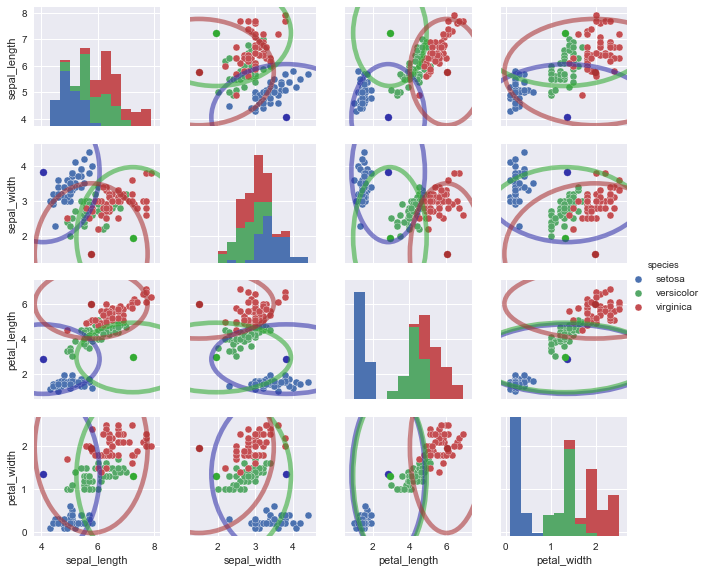

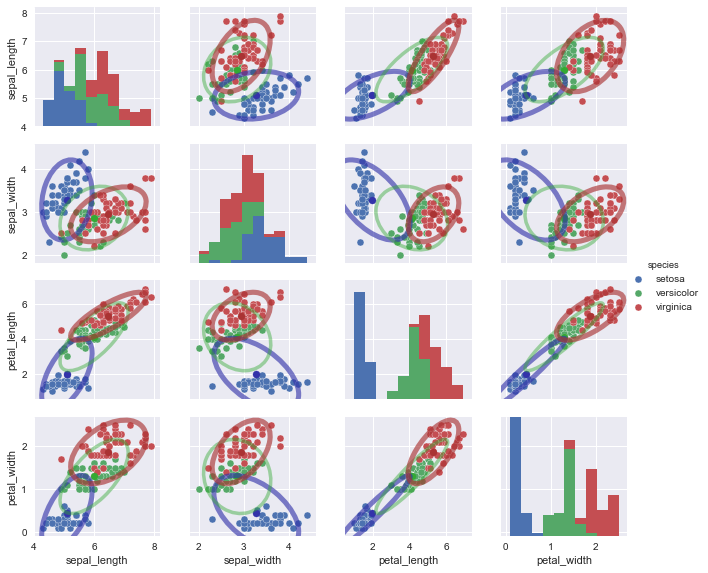

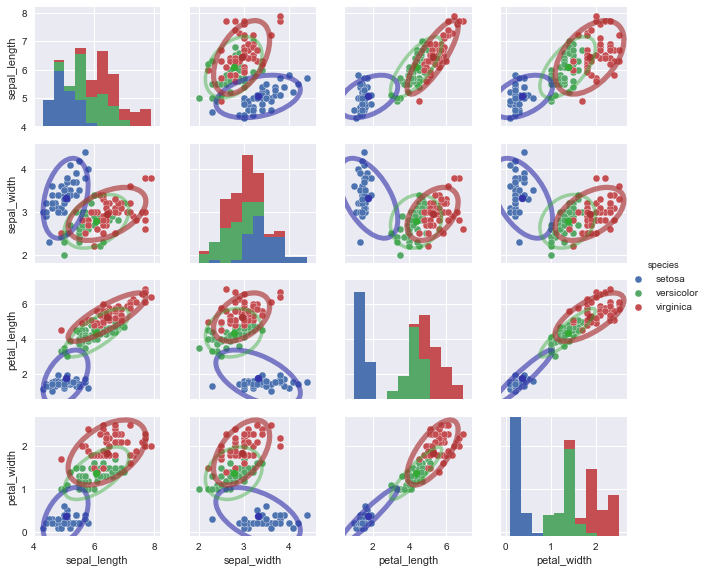

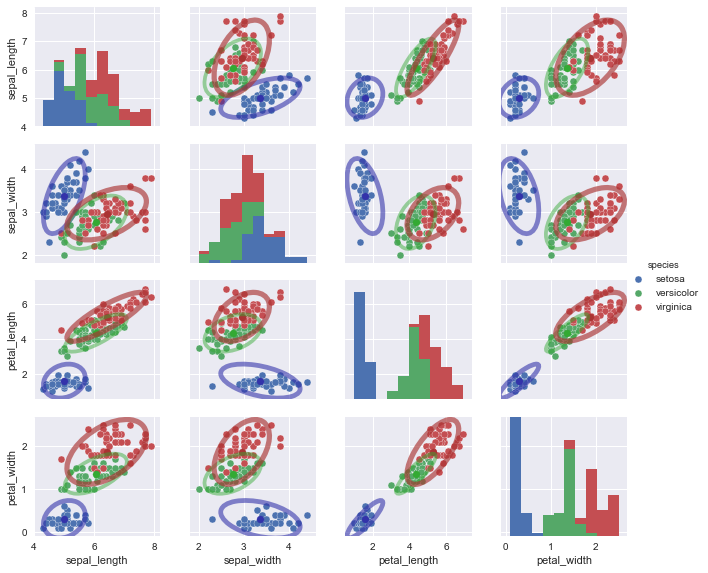

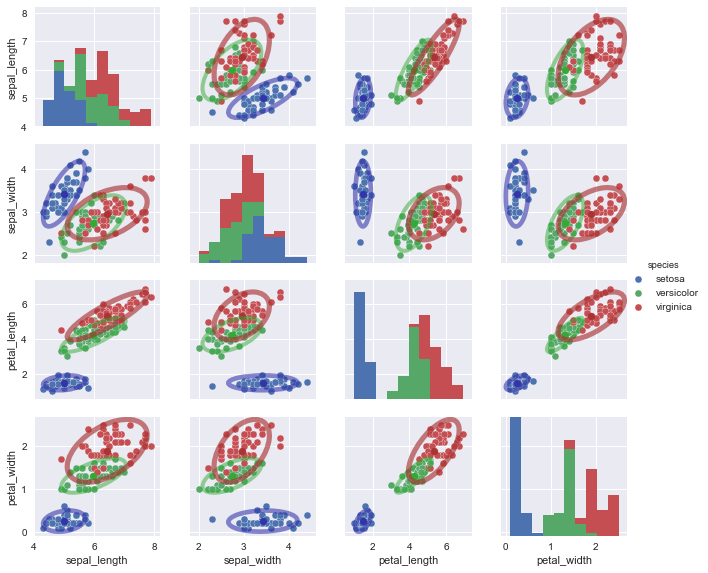

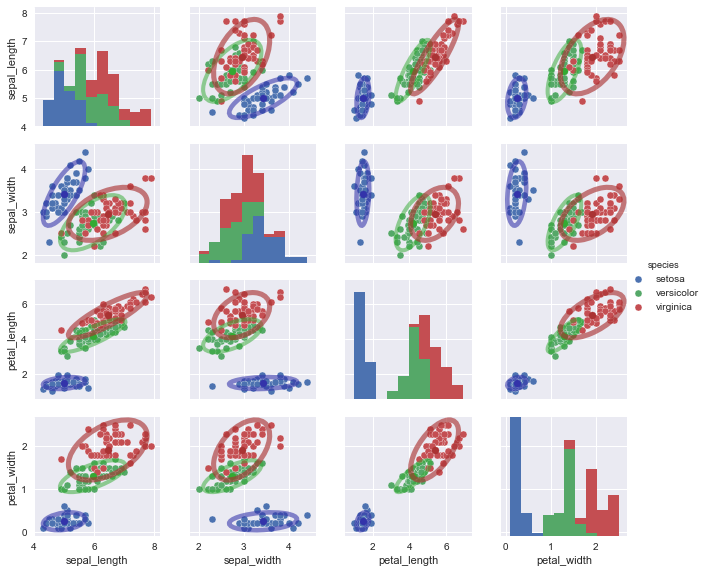

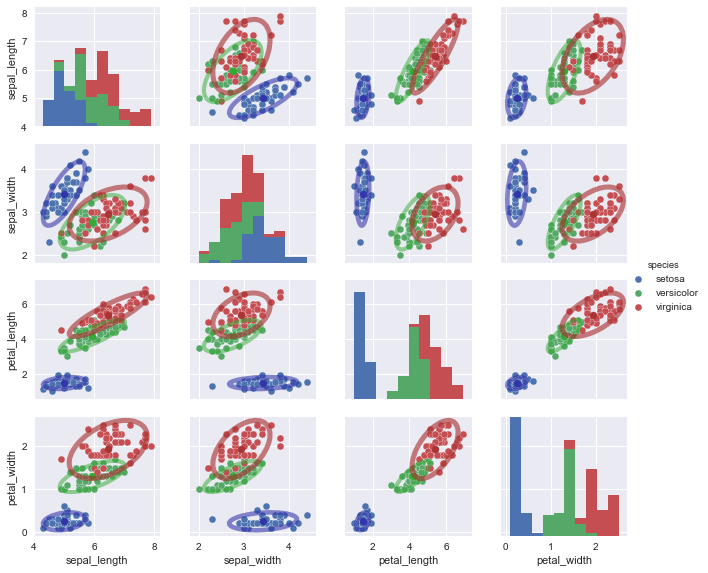

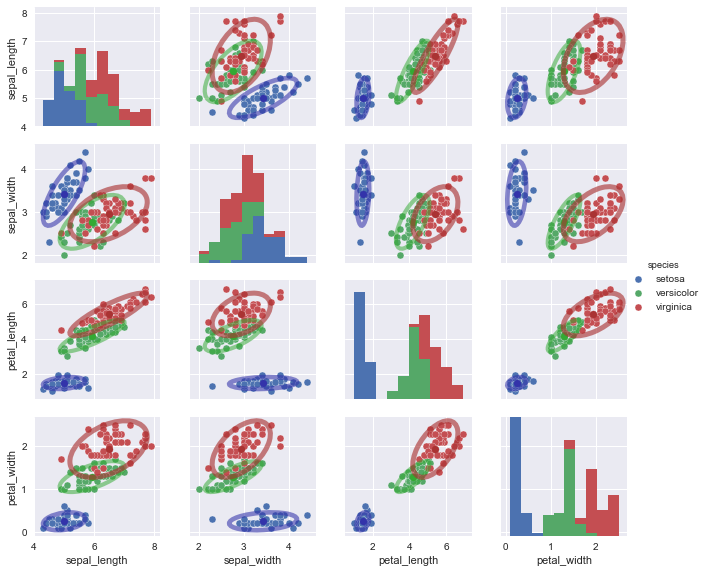

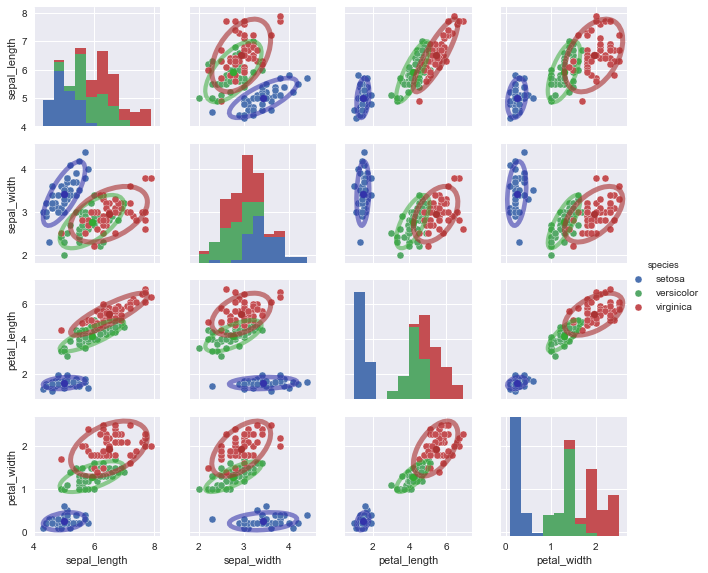

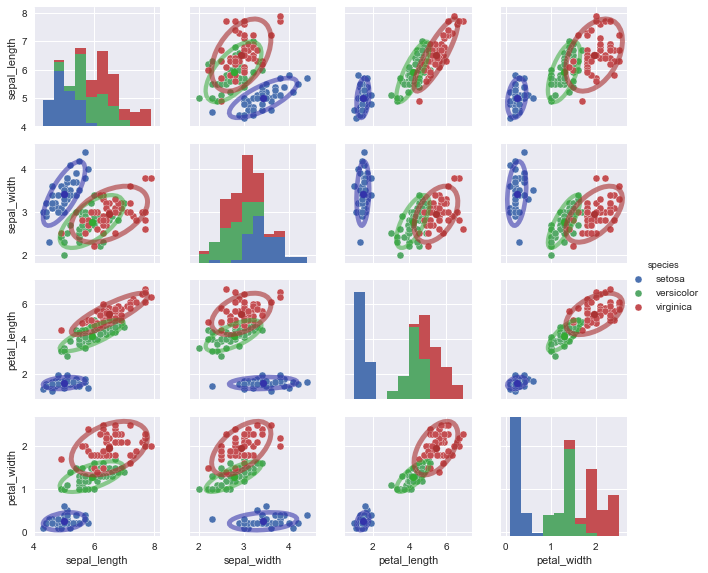

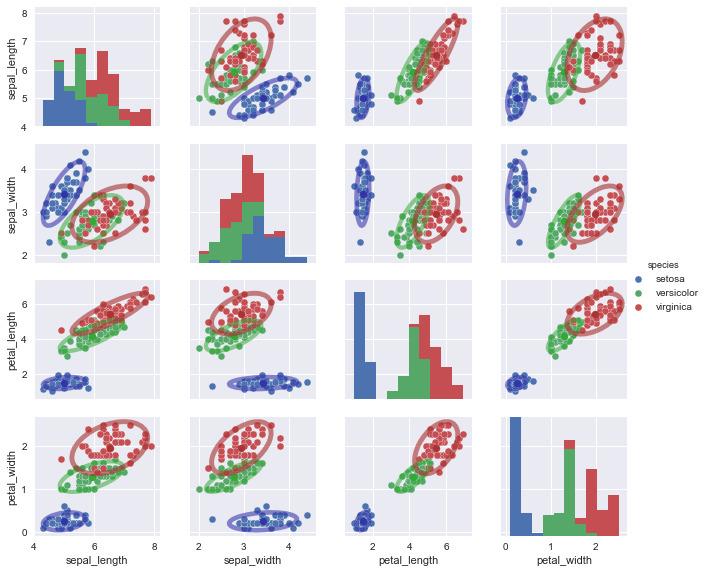

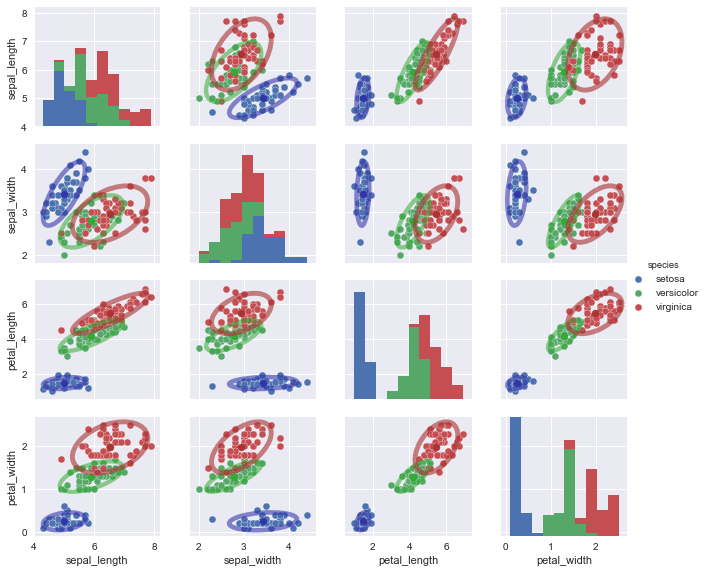

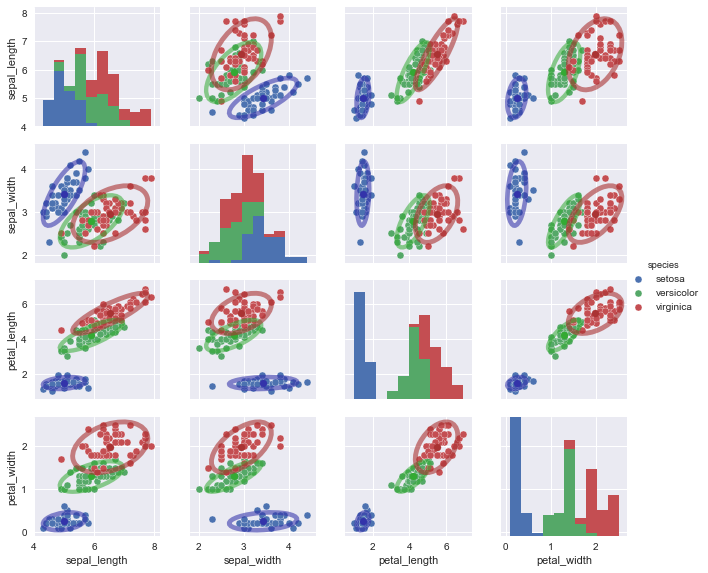

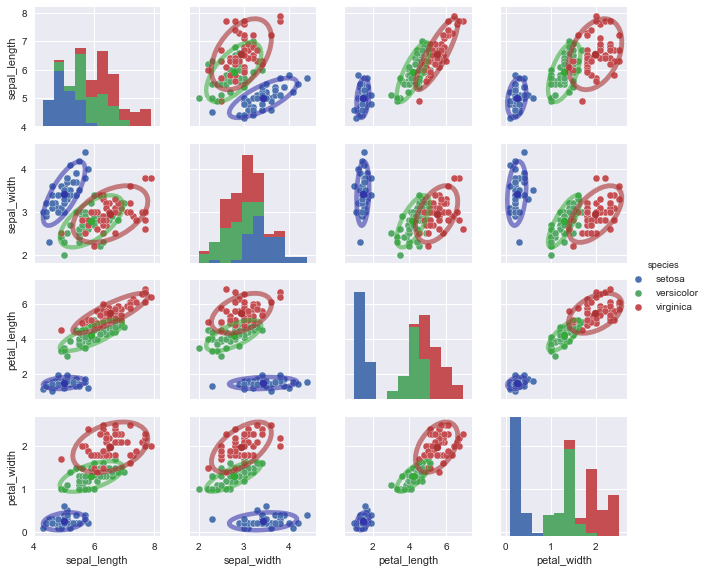

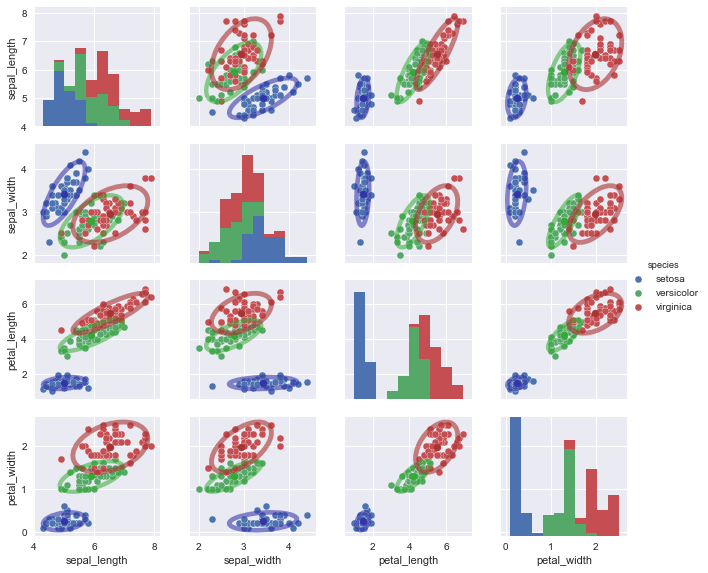

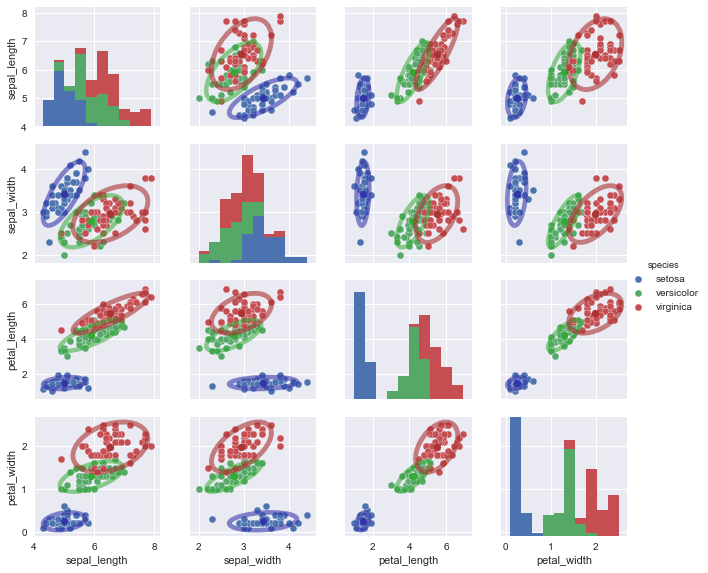

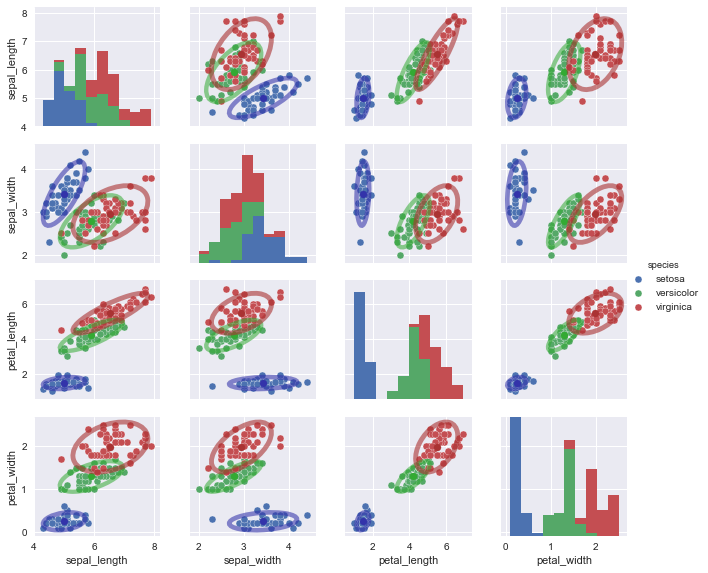

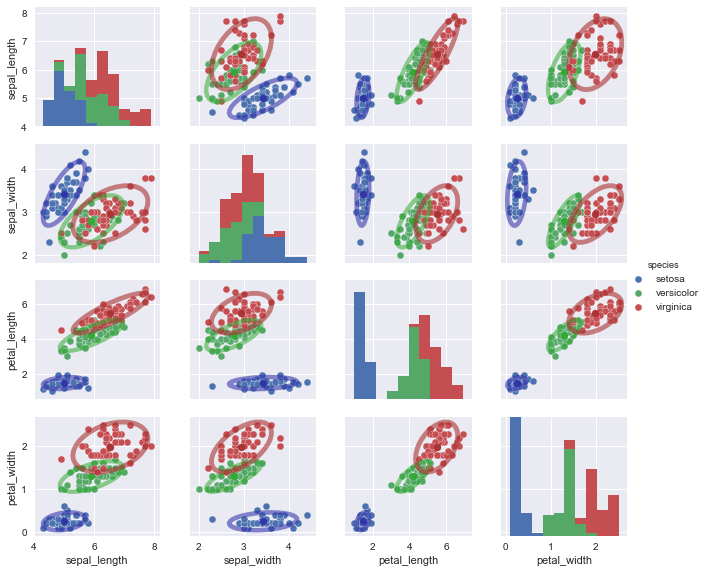

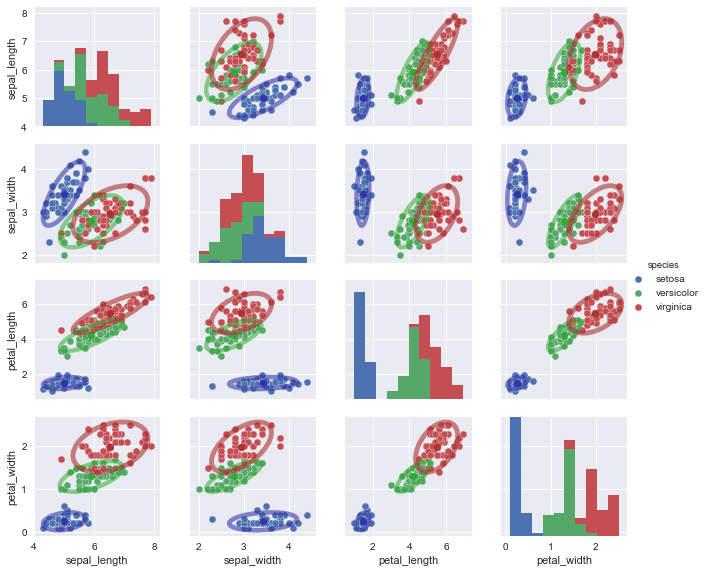

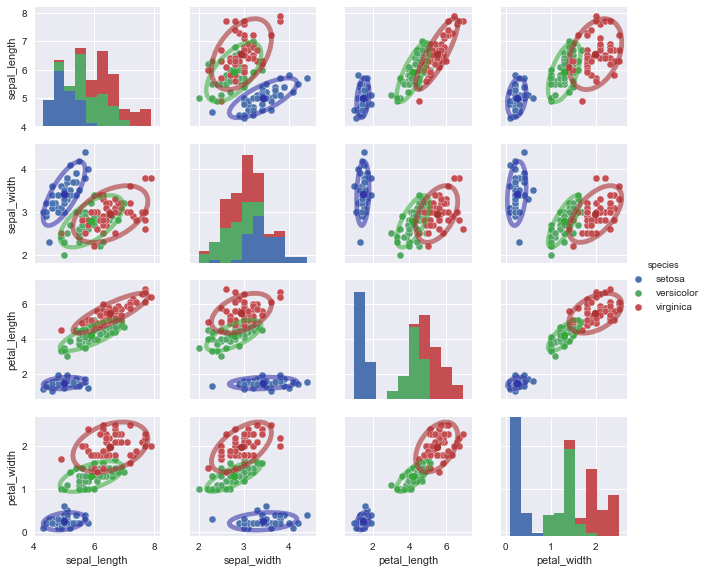

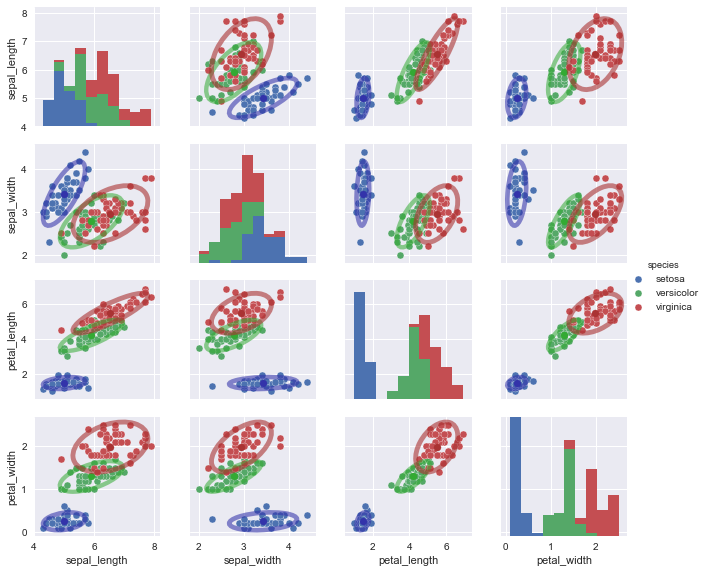

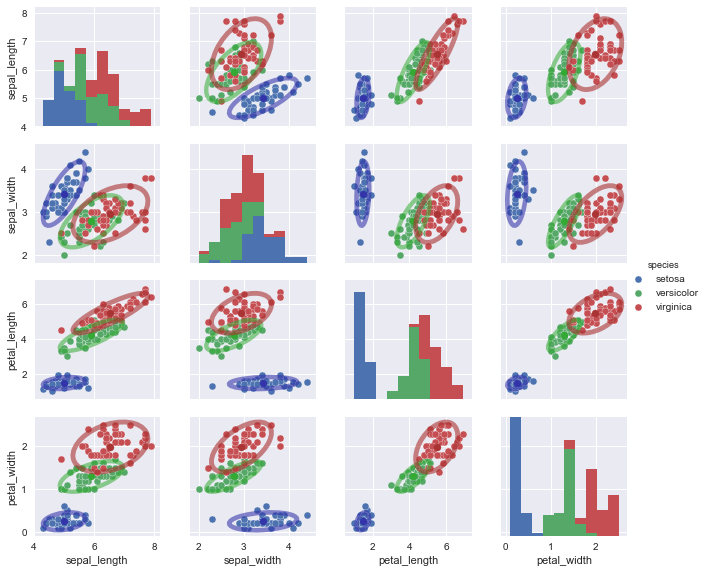

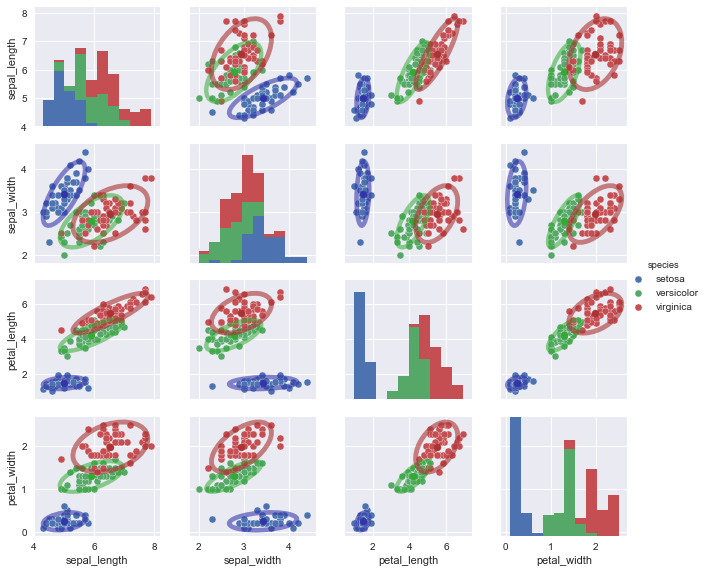

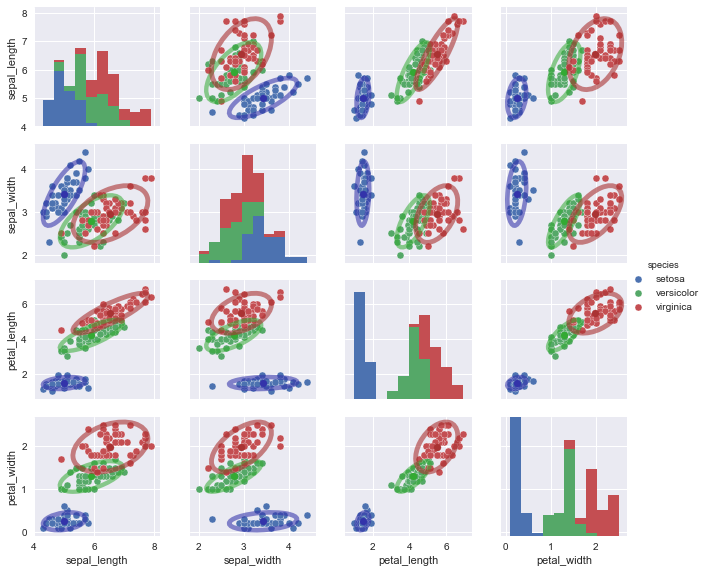

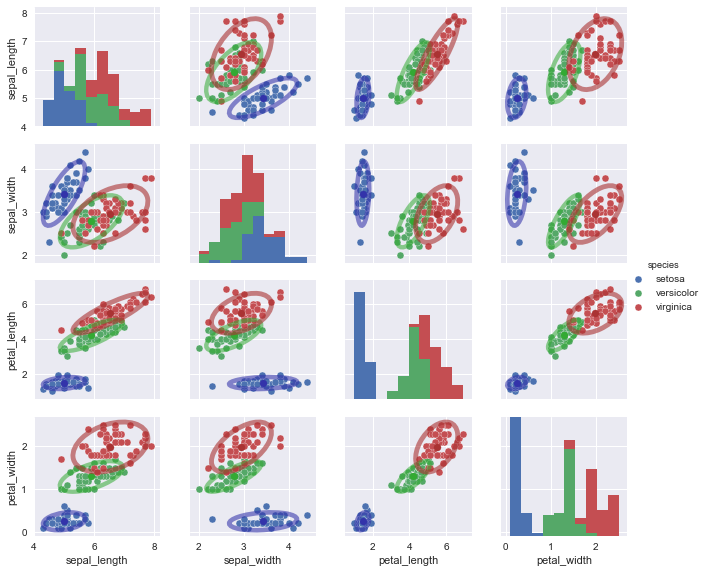

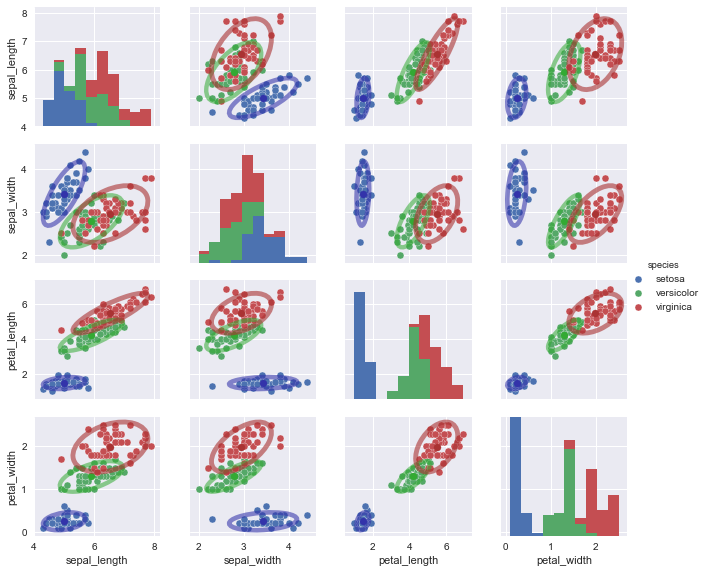

In [60]:
#sns.set(rc={"font.size":14,"axes.titlesize":20,"axes.labelsize":14})
sns.set(font_scale=1)

for fr in range(len(best_seq)):
    best_w, best_mu, best_sigma, best_colors = best_seq[fr]
    
    #f, ax = plt.subplots(figsize=(12,12))
    #plt.scatter(X[:, 0], X[:, 1], c=best_colors)

    grid = sns.pairplot(iris, hue='species')
    grid.fig.set_size_inches(10,8)
    
    for k in range(K):
        #plot_gauss(w, m[k], s[k], cols[k])
        #plot_gauss(best_w[k], best_mu[k], best_sigma[k], cols[k])
        
        for pi in range(0, D):
            for pj in range(pi+1, D):
                cur_mu = np.array([best_mu[k][pi], best_mu[k][pj]])
                cur_sigma = np.array([[best_sigma[k][pi, pi], best_sigma[k][pi, pj]], 
                                      [best_sigma[k][pj, pi], best_sigma[k][pj, pj]]])
                plot_gauss(best_w[k], cur_mu, cur_sigma, cols[k], grid.axes[pj, pi])
                plot_gauss(best_w[k], cur_mu[::-1], cur_sigma[::-1, ::-1], cols[k], grid.axes[pi, pj])
        
    plt.savefig("./save/frame_{}.png".format(fr), dpi=600)
    print(fr)
    
#     plt.show()
#     break

In [8]:
import pickle

In [9]:
with open("fun.pkl", 'wb') as f:
    pickle.dump(best_seq, f)

In [56]:
with open("fun.pkl", 'rb') as f:
    best_seq = pickle.load(f)
len(best_seq)

26